In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from NeighbourClustering import *
import random
import pandas as pd
np.random.seed(1234)

## Parameters
N = 128
T = 200
c = 0.6  # 0.4   # 0.7
r = 1.4 # 0.5  # 0.7
p_loss = 0.5

# Analysis of the top/bottom Quantile
Quantile = 0.1

In [2]:
test_import = ClusteringRateNeighbour_import(np.ones((2,2)))

test_import.mean()

1.0

In [3]:
def Flattened_to_2DIndex(Array, n):
    '''
    Array: 1d enumeration of a previously n x n shaped array
    n: integer with len(Array) == n*n
    '''
    assert(len(Array) == n*n)
    i_index = (Array/n).astype(int)
    j_index = Array%n
    output = np.empty((n*n,2))
    output[:,0] = i_index
    output[:,1] = j_index
    return(output)



def Sample_Agent_B(N_agents, Indices_A, CircularBoundary = True):
    '''
    N_agents: integer (number of agents)
    Indices_A: 2d integer array (kth row of this array gives the x/y coordinates of agent k)
    '''
    
    # create 2d enumeration and flatten it
    Enumeration = np.arange(0,N_agents*N_agents).reshape((N_agents,N_agents))
    FlatEnumeration = Enumeration.flatten()
    
    # transform the flattened enumeration to (i,j) indices of the 2d map
    indices = Flattened_to_2DIndex(FlatEnumeration, N_agents)

    # Do we need to take "periodic" boundary conditions into account?
    if CircularBoundary: # top and bottom and left/right margin are neighbours
        ListIndices_Neighbours_A = [( Indices_A + [1,0])%N_agents,
                                        ( Indices_A + [-1,0])%N_agents,
                                        ( Indices_A + [0,1])%N_agents,
                                        ( Indices_A + [0,-1])%N_agents
                                   ]
        
    else: # Calculate the L1 Distances from the Indices of A
        Norm  = (abs(indices - Indices_A)).sum(axis = 1)
        Norm.reshape((N_agents,N_agents))
    # Safety check
    #ax = sns.heatmap(Norm.reshape((N_agents,N_agents)), linewidth=0.5)
    #plt.title("Distances")
    #plt.show()
    
    # Now create a list of only those indices that are exactly 1 distance away from A
        ListIndices_Neighbours_A = list(indices[Norm == 1])
    
    return(ListIndices_Neighbours_A)
    
    

In [4]:
Sample_Agent_B(N_agents = N, Indices_A = np.array([0,0]).astype(int))

[array([1, 0]), array([127,   0]), array([0, 1]), array([  0, 127])]

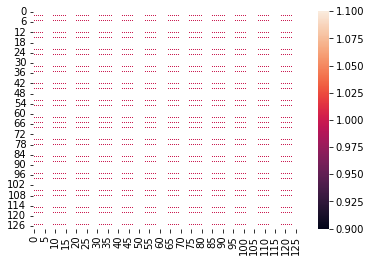

Time unit 0
Mean 1.485246247395756
Median 1.0
Number of contracts 14778


Time unit 1
Mean 2.2150754631828455
Median 1.0
Number of contracts 13748


Time unit 2
Mean 3.2429001013251373
Median 1.0362956828542234
Number of contracts 13632


Time unit 3
Mean 4.574652828299023
Median 1.1102935540592407
Number of contracts 13668


Time unit 4
Mean 6.575032318730404
Median 1.209814850546092
Number of contracts 13838


Time unit 5
Mean 10.975351076931934
Median 1.3278021807261597
Number of contracts 13750


Time unit 6
Mean 15.203101398271782
Median 1.4734744324056916
Number of contracts 13961


Time unit 7
Mean 24.202124373648992
Median 1.6466282976210864
Number of contracts 13955


Time unit 8
Mean 32.46417818981389
Median 1.8652220963703567
Number of contracts 14042


Time unit 9
Mean 70.34450362596036
Median 2.0946779124291686
Number of contracts 13967


Time unit 10
Mean 95.9406297590933
Median 2.3797300272109245
Number of contracts 14060


Time unit 11
Mean 109.09017694943164
Median 2.6

Time unit 92
Mean 25993205662.35017
Median 291992.2291511277
Number of contracts 14802


Time unit 93
Mean 34587304130.5744
Median 339356.2288085757
Number of contracts 14890


Time unit 94
Mean 46727806644.26303
Median 394533.7403379947
Number of contracts 14842


Time unit 95
Mean 38021172201.69972
Median 454364.8612608359
Number of contracts 14918


Time unit 96
Mean 55059806604.33552
Median 523739.7081188061
Number of contracts 14914


Time unit 97
Mean 76949965785.39459
Median 613088.3133329405
Number of contracts 14938


Time unit 98
Mean 123853846006.95786
Median 713306.0302494837
Number of contracts 14915


Time unit 99
Mean 79763200731.25009
Median 830986.5754336072
Number of contracts 14953


Time unit 100
Mean 80598887223.20164
Median 957464.3023990518
Number of contracts 14924


Time unit 101
Mean 142076934534.56665
Median 1100200.3625709298
Number of contracts 14943


Time unit 102
Mean 134062681908.9108
Median 1275512.7719350914
Number of contracts 14949


Time unit 103
M

Time unit 183
Mean 8450347473604267.0
Median 231002461306.11707
Number of contracts 15055


Time unit 184
Mean 9396664675166584.0
Median 268412794019.52936
Number of contracts 15006


Time unit 185
Mean 1.8090228441322584e+16
Median 312666073788.06323
Number of contracts 14991


Time unit 186
Mean 1.0955480395060408e+16
Median 359384209767.4591
Number of contracts 15043


Time unit 187
Mean 1.1710118103767288e+16
Median 420586738924.54175
Number of contracts 15066


Time unit 188
Mean 1.272648014329316e+16
Median 486499063773.1935
Number of contracts 14978


Time unit 189
Mean 1.4558901542718668e+16
Median 569276885463.5933
Number of contracts 15012


Time unit 190
Mean 8618138755847349.0
Median 658613143282.8931
Number of contracts 14993


Time unit 191
Mean 1.4067016906801152e+16
Median 754405411155.0955
Number of contracts 14984


Time unit 192
Mean 1.659529676772505e+16
Median 883116758019.9982
Number of contracts 15010


Time unit 193
Mean 1.6169491708216374e+16
Median 10315317276

In [5]:
AgentsTimeSeries = np.ones((N,N,T+1))


Agents = np.ones((N,N))
AgentsTimeSeries[:,:,0] = Agents
ax = sns.heatmap(Agents, linewidth=0.5)
plt.show()

cluster_top_timeseries = list()
cluster_bottom_timeseries = list()


for t in range(T):  # time units
    
    Contracts = list()
    Distances = list()
    
    for n in range(N*N): # time steps
        
        
        
        # A has the risk and wants to buy insurance
        i_A = np.random.randint(0,N)
        j_A = np.random.randint(0,N)
        
        # Wealth of A and associated cost/gain and maximum Fee
        w_A = Agents[i_A,j_A]
        G = r*w_A
        C = c*w_A
        F_max = w_A - ((w_A + G)**0.5) * ((w_A-C)**0.5)

        
        
        # Neighbourhood of A
        Neighbourhood = Sample_Agent_B(N_agents = N, 
                                       Indices_A = np.array([i_A,j_A]).astype(int))
        Neighbourhood_Offers = dict() # store the F_min offer of each neighbour
        Neighbourhood_Coordinates = dict() # store the coordinates/indices of neighbours
        Neighbours = 0 # enumeration of the neighbours for dict
        for Agent in Neighbourhood:
            i_B, j_B = Agent.astype(int)
            w_B = Agents[i_B, j_B]
            F_min = -w_B  + 0.5*np.sqrt(4*w_B**2 + (G+C)**2 ) + (C-G)/2.
            Neighbourhood_Coordinates[Neighbours] = Agent
            Neighbourhood_Offers[Neighbours] = F_min
            Neighbours += 1
        
        # Identify best offer:
        B = min(Neighbourhood_Offers, key=Neighbourhood_Offers.get)
        i_B, j_B = Neighbourhood_Coordinates[B].astype(int)
        w_B = Agents[i_B, j_B]
        F_min = -w_B  + 0.5*np.sqrt(4*w_B**2 + (G+C)**2 ) + (C-G)/2.

        '''
        print("###########")
        print("A",i_A, j_A)
        print("Positions", Neighbourhood_Coordinates)
        print("Offers", Neighbourhood_Offers)
        print("B", B)
        '''
        
        # Now Gamble
        p = np.random.uniform(0,1)
        win = p>p_loss
        
        if (F_min >= F_max) or (w_B <= C): 
            # B demands more than A is willing to pay:
            # no contract
            
            if win:
                Agents[i_A, j_A] *= (1+r)
            else:
                Agents[i_A,j_A] *= (1-c)
                
                
        elif F_min < F_max and (w_B > C):
            # make a contract at midway fee
            F = 0.5*(F_min + F_max) 
            
            Agents[i_A,j_A] -= F 
            
            
            Contracts += [(i_A, j_A, i_B, j_B)]  # record the signed contract
            #print(Contracts[-1])
            #print(F_min, F, F_max)
            #print(i_A, j_A, i_B, j_B)
            #print("\n")
            if win:
                Agents[i_B, j_B] += (F +  G)
            else:
                Agents[i_B, j_B] += (F-C)
            

    
    
    print("Time unit", t)
    print("Mean", np.mean(Agents))
    print("Median", np.median(Agents))
    #ax = sns.heatmap(np.log(Agents), linewidth=0.5)
    #ax = sns.heatmap(Agents>np.quantile(Agents,0.9), linewidth=0.5)  # Plot the extreme few %
    
    # Clustering    
    cluster_top_timeseries += [ClusteringRateNeighbour_import(Agents>np.quantile(Agents,1-Quantile)).mean()]
    cluster_bottom_timeseries += [ClusteringRateNeighbour_import(Agents<=np.quantile(Agents,Quantile)).mean()]
    
    
    
    # now plot the contracts of this time unit
    print("Number of contracts", len(Contracts))
    
    #for Indices in Contracts:
        #i1, j1, i2, j2 = Indices
        #print([j1,i1], [j2,i2])
        #plt.plot([j1+0.5,j2+0.5], [i1+0.5,i2+0.5], c = "yellow", alpha =0.8)
    #i1, j1, i2, j2 = Contracts[-1]
    #print([j1,i1], [j2,i2])
    #plt.plot([j1+0.5,j2+0.5], [i1+0.5,i2+0.5], c = "white")
    
    
    #plt.show()
    #print("Mean Distance for Contract", np.mean(np.array(Distances)))
    print("\n")
    
    AgentsTimeSeries[:,:,t+1] = Agents

Median 2532931433657.546
TA of EV player 0.0172181975945747


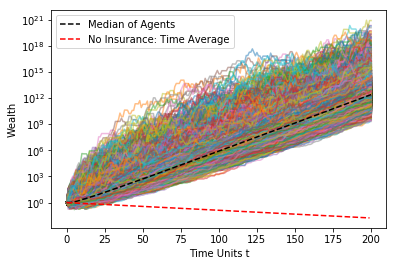

In [6]:
fig, ax = plt.subplots(1,1)
for i in range(N):
    for j in range(N):
        ax.semilogy(AgentsTimeSeries[i,j,:], alpha = 0.5)
        
medians = list()
for t in range(T+1):
    medians  += [np.median(AgentsTimeSeries[:,:,t])]
print("Median",medians[-1])     # 1.659e-13
ax.semilogy(medians, c = "k", linestyle= "--", label="Median of Agents")
ax.set_xlabel("Time Units t")
ax.set_ylabel("Wealth")
#ax.semilogy([0,T],[1,1], c="k")

# Expectation

TA = np.ones(T)
TA =  ((1-c)**(p_loss) * (1+r)**(1-p_loss))**np.arange(T)
ax.semilogy(TA, c="red", linestyle = "--", label="No Insurance: Time Average")
plt.legend()
print("TA of EV player",TA[-1])
plt.show()


## Calculate Clustering

It should be possible to, for both of the top and bottom 10% quantile groups, calculate how many of them have a next neighbour inside this quantile. That's similar to the clustering coefficient. Then, compare that a permuation of ranked agents (CIs via bootstrapping). One can then transition from next-neighbours to the exponential decay of the distance (but still choose 4 agents for each to choose from!) and see if the clustering is persistent or not.

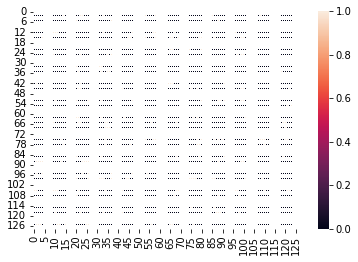

In [7]:
TopDecile = Agents>np.quantile(Agents,0.9)
ax = sns.heatmap(TopDecile, linewidth=0.5)  # Plot the upper few %


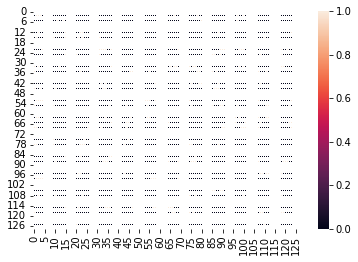

In [8]:

BottomDecile = Agents<=np.quantile(Agents,0.1)
ax = sns.heatmap(BottomDecile, linewidth=0.5)  # Plot the upper few %


In [9]:
test_bottom = ClusteringRateNeighbour_import(BottomDecile)
test_top = ClusteringRateNeighbour_import(TopDecile)

test_bottom.mean(), test_top.mean()

(0.7827943868212325, 0.7809640024405126)

### Now upper and lower half

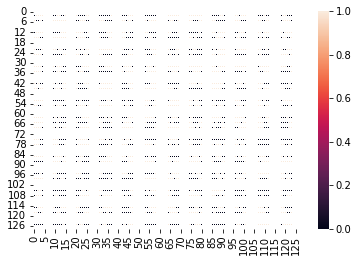

In [10]:
ax = sns.heatmap(Agents < np.median(Agents),
                 linewidth=0.5)  # Plot the upper few %


### Clustering of Random Ensembles

Just create many shuffled matrices of the same shape and calculate their clustering coefficient to get an expected value and CIs for the Null-Hypothesis "there is no structure". Although this is also calculated below, it should be clear that the expected value should be the same for both of these groups.

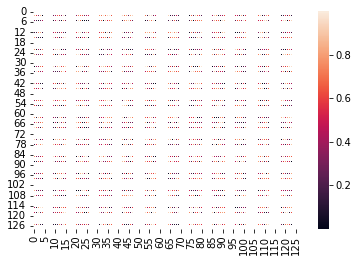

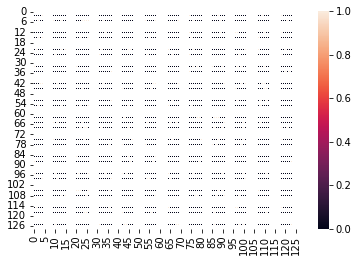

0.3563148261134838

In [11]:
RandomMatrix = np.random.uniform(size = (N,N) )
sns.heatmap(RandomMatrix, linewidth = 0.5)
plt.show()
RandomMatrix = RandomMatrix <= np.quantile(RandomMatrix,0.1)
sns.heatmap(RandomMatrix, linewidth = 0.5)
plt.show()
ClusteringRateNeighbour_import(RandomMatrix).mean()

In [12]:
np.log(AgentsTimeSeries[:,:,T].max()), np.log(AgentsTimeSeries[:,:,T].min())

(48.14831770500374, 21.46302191774162)

In [13]:
# Real Time Series Values vs. their ranking via .argsort().argsort():
# results should be identical! Quantiles remain in the same position!

q = 0.08

n_Ens = 100

for t in range(5,100,20):
    Bottom_Clust = list()
    Top_Clust = list()
    Bottom_Clust2 = list()
    Top_Clust2 = list()
    
    for Ensemble in range(n_Ens):
        RandomMatrix =  np.random.permutation(np.log(AgentsTimeSeries[:,:,t]).flatten()).reshape((N,N)) #np.random.normal(size = (N,N) ) #

        RandomBottom = RandomMatrix <= np.quantile(RandomMatrix,q)
        Bottom_Clust += [ClusteringRateNeighbour_import(RandomBottom).mean()]

        RandomTop = RandomMatrix > np.quantile(RandomMatrix,1-q)
        Top_Clust += [ClusteringRateNeighbour_import(RandomTop).mean()]

        #print(np.log(np.quantile(RandomMatrix,0.1)), np.log(np.quantile(RandomMatrix,0.9)))

        
        RM2 = RandomMatrix.flatten().argsort().argsort().reshape(RandomMatrix.shape)
        RandomBottom2 = RM2 <= np.quantile(RM2,q)
        Bottom_Clust2 += [ClusteringRateNeighbour_import(RandomBottom2).mean()]

        RandomTop2 = RM2 > np.quantile(RM2,1-q)
        Top_Clust2 += [ClusteringRateNeighbour_import(RandomTop2).mean()]

        
        
        
        
    Bottom_Clust = np.array(Bottom_Clust)
    Top_Clust = np.array(Top_Clust)
    print("\n",t,"\n",np.round(np.array([np.array(Bottom_Clust).mean(),np.array(Bottom_Clust).std(),
           np.array(Top_Clust).mean(),np.array(Top_Clust).std()]),2),"\n",
         np.round(np.array([np.array(Bottom_Clust2).mean(),np.array(Bottom_Clust2).std(), # here: argsort() index
           np.array(Top_Clust2).mean(),np.array(Top_Clust2).std()]),2))
    print(len(ClusteringRateNeighbour_import(RandomTop)), len(ClusteringRateNeighbour_import(RandomBottom)))


 5 
 [0.28 0.01 0.28 0.02] 
 [0.28 0.01 0.28 0.02]
1311 1311

 25 
 [0.28 0.02 0.28 0.01] 
 [0.28 0.02 0.28 0.01]
1311 1311

 45 
 [0.28 0.02 0.29 0.02] 
 [0.28 0.02 0.29 0.02]
1311 1311

 65 
 [0.28 0.02 0.29 0.02] 
 [0.28 0.02 0.29 0.02]
1311 1311

 85 
 [0.28 0.02 0.28 0.02] 
 [0.28 0.02 0.28 0.02]
1311 1311


In [14]:
np.quantile(RandomMatrix,q),np.quantile(RandomMatrix,1-q), np.median(RandomMatrix)

(8.939653254012988, 15.589693892572809, 11.412421907326516)

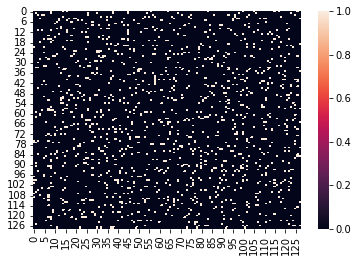

In [15]:
sns.heatmap(RandomTop)

#### THEORY
Via Binomial-like random variable X with probability q and 4 neighbour slots: 
$$ ClusteringRate = 1- P(X=0) = 1-(1-q)^4  $$ 

In [16]:
1-(1-q)**4

0.2836070399999999

In [17]:
nr = 1000
q = 0.08
M = np.random.normal(0,1,(nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),q)).mean())

M = np.random.pareto(1,(nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),q)).mean())

M = np.random.poisson(1000,(nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),q)).mean())

M = np.random.logistic(0,1,(nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),q)).mean())

M = np.random.standard_cauchy((nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),q)).mean())


0.2845875
0.2834375
0.28064425983791885
0.28115
0.2859875


In [18]:
n_Ens = 1000
Bottom_Clust = list()
Top_Clust = list()

for Ensemble in range(n_Ens):
    RandomMatrix =  np.random.permutation(AgentsTimeSeries[:,:,-1].flatten()).reshape((N,N)) #np.random.normal(size = (N,N) ) #

    RandomBottom = RandomMatrix <= np.quantile(RandomMatrix,0.1)
    Bottom_Clust += [ClusteringRateNeighbour_import(RandomBottom).mean()]
    
    RandomTop = RandomMatrix > np.quantile(RandomMatrix,0.9)
    Top_Clust += [ClusteringRateNeighbour_import(RandomTop).mean()]
    
    #print(np.log(np.quantile(RandomMatrix,0.1)), np.log(np.quantile(RandomMatrix,0.9)))
    
Bottom_Clust = np.array(Bottom_Clust)
Top_Clust = np.array(Top_Clust)
Top_Clust.mean(), Bottom_Clust.mean()

(0.3430189139719341, 0.3437528981086028)

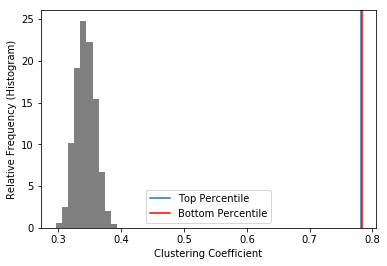

In [19]:
plt.hist(Top_Clust, color="grey", density = True)
plt.axvline(test_top.mean(), label="Top Percentile")
plt.axvline(test_bottom.mean(), c="red", label="Bottom Percentile")
plt.legend()
plt.xlabel("Clustering Coefficient")
plt.ylabel("Relative Frequency (Histogram)")
plt.show()

In [20]:
test_top.mean(), test_bottom.mean()

(0.7809640024405126, 0.7827943868212325)

In [21]:
Top_Clust.mean() + Top_Clust.std()

0.35824777479219244

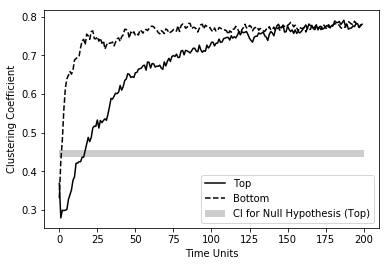

In [22]:
# Top_Clust
plt.axvspan(xmin= 0 ,xmax = len(cluster_top_timeseries), 
            ymin=Top_Clust.mean() - Top_Clust.std(), 
            ymax=Top_Clust.mean() + Top_Clust.std(), 
            alpha = 0.4, facecolor="grey",label="CI for Null Hypothesis (Top)")
# Bottom_Clust
#plt.axvspan(xmin= 0 ,xmax = len(cluster_top_timeseries), 
#            ymin=Bottom_Clust.mean() - Bottom_Clust.std(), 
#            ymax=Bottom_Clust.mean() + Bottom_Clust.std(), 
#            alpha = 0.4, facecolor="red",label="CI for Null Hypothesis (Bottom)")
plt.plot(cluster_top_timeseries, label="Top", c="k",)
plt.plot(cluster_bottom_timeseries,"--", label="Bottom", c="k")
plt.xlabel("Time Units")
plt.ylabel("Clustering Coefficient")
plt.legend()
plt.savefig("10%_quantiles_N="+str(N)+"_T="+str(T)+"_c="+str(c)+"_r="+str(r)+"_p_loss="+str(p_loss)+".pdf")

## Questions:

- How stable is the position of an agent?
- How much do the members of the top/bottom percentile fluctuate? (Spearman's rank correlation coefficient, Friedman test?)
- which wealth distribution arises?


(array([2.710e+02, 3.647e+03, 6.315e+03, 3.881e+03, 1.568e+03, 4.860e+02,
        1.400e+02, 5.500e+01, 1.700e+01, 4.000e+00]),
 array([21.46302192, 24.1315515 , 26.80008108, 29.46861065, 32.13714023,
        34.80566981, 37.47419939, 40.14272897, 42.81125855, 45.47978813,
        48.14831771]),
 <a list of 10 Patch objects>)

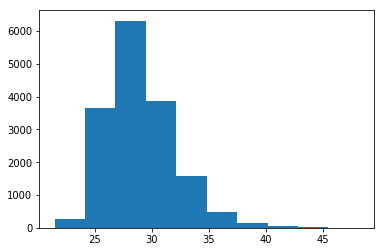

In [24]:
plt.hist(np.log(AgentsTimeSeries[:,:,-1].flatten()))

In [26]:
AgentsTimeSeries.shape

(128, 128, 201)

In [40]:
DF = pd.DataFrame({})

for t in range(1,AgentsTimeSeries.shape[2]):
    Agents_t = AgentsTimeSeries[:,:,t].flatten()
    DF["TU "+str(t)] = Agents_t  # TU = Time Unit

/home/users/t_wand01/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [44]:
DF_Small = pd.DataFrame({})

for t in range(10, AgentsTimeSeries.shape[2],10):
    DF_Small["TU_"+str(t)] =  DF["TU "+str(t)].copy()

In [46]:
DF_Small.corr(method='spearman').round(2)

,TU_10,TU_20,TU_30,TU_40,TU_50,TU_60,TU_70,TU_80,TU_90,TU_100,TU_110,TU_120,TU_130,TU_140,TU_150,TU_160,TU_170,TU_180,TU_190,TU_200
TU_10,1.00,0.68,0.54,0.45,0.39,0.34,0.30,0.28,0.25,0.23,0.21,0.19,0.17,0.16,0.15,0.14,0.13,0.12,0.11,0.10
TU_20,0.68,1.00,0.79,0.66,0.57,0.50,0.45,0.41,0.37,0.34,0.31,0.29,0.26,0.25,0.23,0.21,0.20,0.19,0.18,0.17
TU_30,0.54,0.79,1.00,0.84,0.72,0.64,0.57,0.52,0.47,0.44,0.40,0.37,0.35,0.32,0.30,0.28,0.26,0.25,0.23,0.22
TU_40,0.45,0.66,0.84,1.00,0.87,0.76,0.69,0.63,0.57,0.52,0.48,0.44,0.41,0.38,0.35,0.33,0.31,0.29,0.27,0.26
TU_50,0.39,0.57,0.72,0.87,1.00,0.88,0.79,0.72,0.65,0.60,0.56,0.51,0.48,0.44,0.41,0.38,0.36,0.34,0.32,0.30
TU_60,0.34,0.50,0.64,0.76,0.88,1.00,0.90,0.81,0.74,0.68,0.62,0.58,0.54,0.50,0.46,0.43,0.41,0.38,0.36,0.34
TU_70,0.30,0.45,0.57,0.69,0.79,0.90,1.00,0.91,0.83,0.75,0.70,0.65,0.60,0.55,0.51,0.48,0.45,0.43,0.40,0.38
TU_80,0.28,0.41,0.52,0.63,0.72,0.81,0.91,1.00,0.91,0.83,0.77,0.71,0.66,0.62,0.57,0.53,0.50,0.48,0.45,0.43
TU_90,0.25,0.37,0.47,0.57,0.65,0.74,0.83,0.91,1.00,0.92,0.85,0.78,0.73,0.67,0.63,0.58,0.55,0.52,0.49,0.46
TU_100,0.23,0.34,0.44,0.52,0.60,0.68,0.75,0.83,0.92,1.00,0.92,0.85,0.79,0.73,0.68,0.64,0.60,0.56,0.53,0.50


#### Significance Test

In [56]:
Spearman = DF.corr(method = "spearman").to_numpy()
Spearman.round(1)

array([[1. , 0.7, 0.6, ..., 0. , 0. , 0. ],
       [0.7, 1. , 0.8, ..., 0.1, 0.1, 0.1],
       [0.6, 0.8, 1. , ..., 0.1, 0.1, 0.1],
       ...,
       [0. , 0.1, 0.1, ..., 1. , 1. , 1. ],
       [0. , 0.1, 0.1, ..., 1. , 1. , 1. ],
       [0. , 0.1, 0.1, ..., 1. , 1. , 1. ]])

In [57]:
n_obs = len(AgentsTimeSeries[:,:,-1].flatten())
n_obs
t = Spearman * ( (n_obs - 2 )/(1 - Spearman**2) )**0.5  # Test significance via student's t
t

/home/users/t_wand01/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([[          inf,  137.82885338,  103.03818908, ...,    4.46760737,
           4.4792421 ,    4.59863358],
       [ 137.82885338,           inf,  204.02776138, ...,    6.42866528,
           6.53570579,    6.61360356],
       [ 103.03818908,  204.02776138,           inf, ...,    7.49165268,
           7.64936568,    7.76292742],
       ...,
       [   4.46760737,    6.42866528,    7.49165268, ...,           inf,
        1183.80340924,  835.33185148],
       [   4.4792421 ,    6.53570579,    7.64936568, ..., 1183.80340924,
                  inf, 1159.78574507],
       [   4.59863358,    6.61360356,    7.76292742, ...,  835.33185148,
        1159.78574507,           inf]])

Ignore the inf on diagonal: that is trivial because or Spearman-r = 1. Results are extremely high t-statistics and therefore highly significant, but that may be an effect due to the large n (~16.000).

#### Higher Diagonals

The diagonal of Spearman-r has always 1. Let's compute the mean of the diagonals beyond the main diagonal.

In [64]:
Offsets = np.arange(1,Spearman.shape[0]).astype(int)
Means = []
Stds = []


for offset in Offsets:
    Means += [np.mean(np.diagonal(Spearman, offset=offset))]
    Stds += [np.std(np.diagonal(Spearman, offset=offset))]

Means = np.array(Means)
Stds = np.array(Stds)

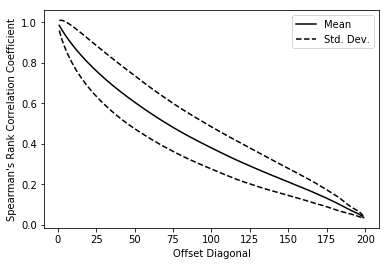

In [67]:
plt.plot(Offsets, Means, c="k", label="Mean")
plt.plot(Offsets, Means+Stds, "--",c="k", label="Std. Dev.")
plt.plot(Offsets, Means-Stds, "--",c="k")
plt.xlabel("Offset Diagonal")
plt.ylabel("Spearman's Rank Correlation Coefficient")
plt.legend()
plt.show()